<a href="https://colab.research.google.com/github/nik1997/VaR_CVaR/blob/master/Portfolio_VaR_Currencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import numpy as np
import datetime as dt
from scipy.stats import norm
import matplotlib.pyplot as plt
from tabulate import tabulate
from IPython.display import display

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
'''
    'DEXUSEU' -> 1 EUR = x USD
    'DEXUSUK' -> 1 GBP = x USD
    'DEXUSAL' -> 1 AUD = x USD
'''

# Create out portfolio of currencies
tickers = ['DEXUSEU', 'DEXUSUK', 'DEXUSAL']


# Getting the closing prices
data = pdr.get_data_fred(tickers)

data

,DEXUSEU,DEXUSUK,DEXUSAL
DATE,,,
2015-04-27,1.0892,1.5235,0.7859
2015-04-28,1.0979,1.5328,0.8017
2015-04-29,1.1174,1.5485,0.8065
2015-04-30,1.1162,1.5328,0.7867
2015-05-01,1.1194,1.5137,0.7813
...,...,...,...
2020-04-13,1.0906,1.2518,0.6380
2020-04-14,1.0971,1.2617,0.6419
2020-04-15,1.0909,1.2523,0.6328


In [4]:
# getting percentage change which the return in the FX rate
df_changes = data.pct_change()
df_changes = df_changes[1:]
df_changes.tail()

,DEXUSEU,DEXUSUK,DEXUSAL
DATE,,,
2020-04-13,-0.004109,0.002643,0.004883
2020-04-14,0.005960,0.007909,0.006113
2020-04-15,-0.005651,-0.007450,-0.014177
2020-04-16,-0.006325,-0.007187,-0.004267
2020-04-17,0.003967,0.005630,0.008887


In [5]:
# Getting the Co-variance matrix
cov_matrix = df_changes.cov()
cov_matrix

,DEXUSEU,DEXUSUK,DEXUSAL
DEXUSEU,0.000025,0.000016,0.000014
DEXUSUK,0.000016,0.000039,0.000017
DEXUSAL,0.000014,0.000017,0.000038


In [77]:
# Assuming we have to get 100,000 EUR, 100,000 GBP and 100,000 AUD from our buyers in a month 
currencies = ['EUR', 'GBP', 'AUD']
paymentsLocal = np.array([100000, 100000, 100000]) #100K in local currencies
paymentsUSD = (data[-1:].to_numpy()[0] * paymentsLocal)
totalEarningsUSD = sum(paymentsUSD)
weights = paymentsUSD/totalEarningsUSD

df_current = pd.DataFrame({
    'Currency': currencies,
    'Local Payment': paymentsLocal,
    'Conversion Rate': data[-1:].to_numpy()[0],
    'Payment in USD': paymentsUSD,
    'Weights (%)': np.round(weights * 100, 2)
})

display(df_current)
print('\n')

print('Total Earnings in USD at Current Spot Rate: ', totalEarningsUSD)

,Currency,Local Payment,Conversion Rate,Payment in USD,Weights (%)
0,EUR,100000,1.0883,108830.0,36.59
1,GBP,100000,1.2503,125030.0,42.04
2,AUD,100000,0.6357,63570.0,21.37




Total Earnings in USD at Current Spot Rate:  297430.0


In [78]:
'''
    If a portfolio has multiple assets, its volatility is calculated using a matrix. 
    A variance-covariance matrix is computed for all the assets. 
    The vector of the weights of the assets in the portfolio is multiplied 
    by the transpose of the vector of the weights of 
    the assets multiplied by the covariance matrix of all of the 
    assets (Investopedia)
'''

# Calculating portfolio mean and standard deviation

# mean of each stock
avg_changes = df_changes.mean()

# Mean of porfolio
portfolio_mean = avg_changes.dot(weights)

# Calculate portfolio standard deviation
portfolio_stdev = np.sqrt(weights.T.dot(cov_matrix).dot(weights))

print('Portfolio mean changes is: ', portfolio_mean)
print('Portfolio standard deviation is: ', portfolio_stdev)

Portfolio mean changes is:  -8.220163903927414e-05
Portfolio standard deviation is:  0.004712688641368084


$$Porfolio\ Standard\ Deviation = \sqrt{weights^T . (covariance\ matrix) . weights}$$

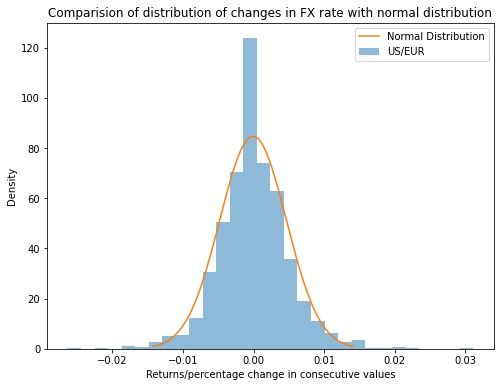

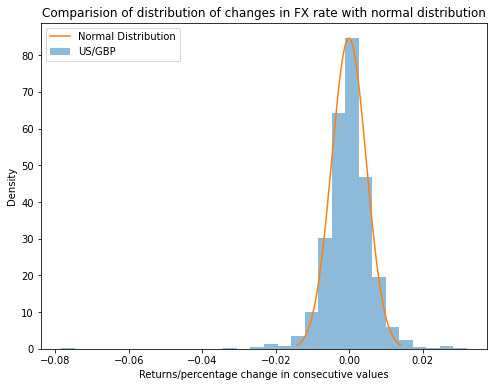

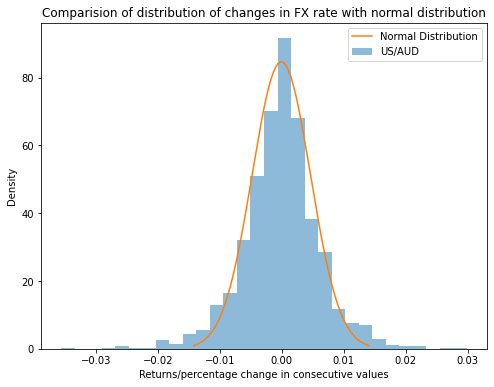

In [79]:
x = np.linspace(portfolio_mean -3 * portfolio_stdev, portfolio_mean + 3 * portfolio_stdev, 1000)
plt.figure(figsize=(8, 6))
plt.hist(df_changes['DEXUSEU'], alpha=0.5, bins=30, density=True, label='US/EUR')
plt.plot(x, norm.pdf(x,portfolio_mean,portfolio_stdev), label='Normal Distribution')
plt.legend()
plt.xlabel('Returns/percentage change in consecutive values')
plt.ylabel('Density')
plt.title('Comparision of distribution of changes in FX rate with normal distribution')
plt.show()

x = np.linspace(portfolio_mean -3 * portfolio_stdev, portfolio_mean + 3 * portfolio_stdev, 1000)
plt.figure(figsize=(8, 6))
plt.hist(df_changes['DEXUSUK'], alpha=0.5, bins=30, density=True, label='US/GBP')
plt.plot(x, norm.pdf(x,portfolio_mean,portfolio_stdev), label='Normal Distribution')
plt.legend()
plt.xlabel('Returns/percentage change in consecutive values')
plt.ylabel('Density')
plt.title('Comparision of distribution of changes in FX rate with normal distribution')
plt.show()

x = np.linspace(portfolio_mean -3 * portfolio_stdev, portfolio_mean + 3 * portfolio_stdev, 1000)
plt.figure(figsize=(8, 6))
plt.hist(df_changes['DEXUSAL'], alpha=0.5, bins=30, density=True, label='US/AUD')
plt.plot(x, norm.pdf(x,portfolio_mean,portfolio_stdev), label='Normal Distribution')
plt.legend()
plt.xlabel('Returns/percentage change in consecutive values')
plt.ylabel('Density')
plt.title('Comparision of distribution of changes in FX rate with normal distribution')
plt.show()

In [82]:
# Our confidence interval 
conf_levels = [0.10, 0.05, 0.01]

def tabulateData(values, conf_levels, title='VaR'):
    table = [[('{0}%'.format((1-conf_levels[i])*100)), values[i]] for i in range(len(conf_levels))]    
    print(tabulate(table,
               headers = ['Confidence Level', title]))
    
def calc_VaR(alpha, mu, std, portfolio_value):
    # VaR = (E(returns) - PPf@Confidence interval * stdev) * portfolio_value
    return abs((mu - norm.ppf(alpha) * std) * portfolio_value)

def calc_CVaR(alpha, mu, std, portfolio_value):
    return ( mu +alpha**-1 * norm.pdf(norm.ppf(alpha))* std )*portfolio_value


### VaR
parametric_VaRs = [calc_VaR(conf_level, portfolio_mean, portfolio_stdev, totalEarningsUSD) for conf_level in conf_levels]
tabulateData(parametric_VaRs, conf_levels, 'VaR 1-day')

print('\n')

### CVaR
parametric_CVaRs = [calc_CVaR(conf_level, portfolio_mean, portfolio_stdev, totalEarningsUSD) for conf_level in conf_levels]
tabulateData(parametric_CVaRs, conf_levels, 'CVaR 1-day')

Confidence Level      VaR 1-day
------------------  -----------
90.0%                   1771.9
95.0%                   2281.13
99.0%                   3236.38


Confidence Level      CVaR 1-day
------------------  ------------
90.0%                    2435.5
95.0%                    2866.84
99.0%                    3711.37


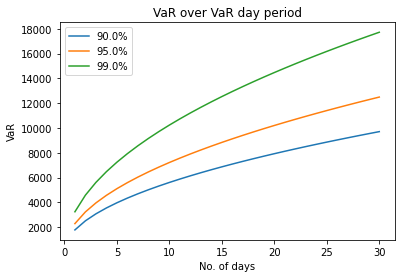

Confidence Level      VaR at 30 days
------------------  ----------------
90.0%                        9705.07
95.0%                       12494.3
99.0%                       17726.4


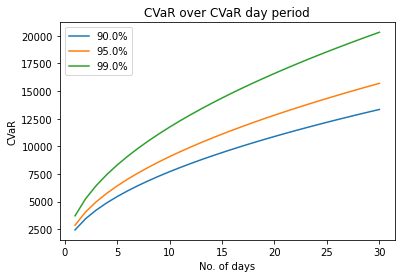

Confidence Level      VaR at 30 days
------------------  ----------------
90.0%                        13339.8
95.0%                        15702.4
99.0%                        20328


In [83]:
# VaR over n-day period
# Multiply 1-day var by square root of time peiord
# assuming stddev in stock returns increase by square root of time
def plot_n_day_var(VaRs_array, title, num_days, conf_levels):
    for idx, VaRs_nday in enumerate(VaRs_array):
        plt.plot(range(1, num_days+1), VaRs_nday, label='{}%'.format((1-conf_levels[idx])*100))
    plt.xlabel('No. of days')
    plt.ylabel('{0}'.format(title))
    plt.title('{0} over {0} day period'.format(title, num_days))
    plt.legend()
    plt.show()


num_days = 30

VaRs_array = [[np.round(VaR * np.sqrt(i),2) for i in range(1, num_days + 1)] for VaR in VaRs]
VaR_n_day = [vals[-1] for vals in VaRs_array]
plot_n_day_var(VaRs_array, 'VaR', num_days, conf_levels)
tabulateData(VaR_n_day, conf_levels, title='VaR at 30 days')


CVaRs_array = [[np.round(CVaR * np.sqrt(i),2) for i in range(1, num_days + 1)] for CVaR in CVaRs]
CVaR_n_day = [vals[-1] for vals in CVaRs_array]
plot_n_day_var(CVaRs_array, 'CVaR', num_days, conf_levels)
tabulateData(CVaR_n_day, conf_levels, title='VaR at 30 days')

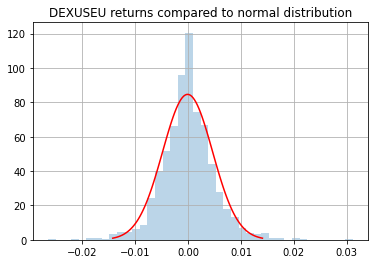

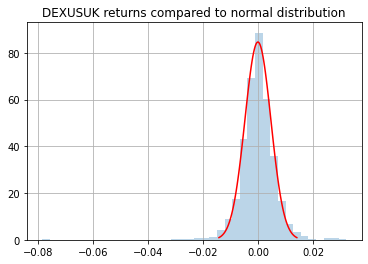

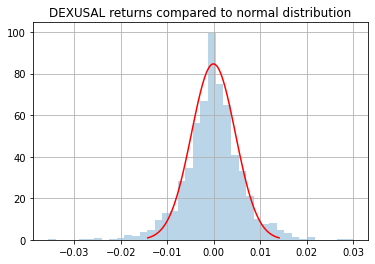

In [84]:
for ticker in tickers:
    df_changes[ticker].hist(bins=40, density=True, histtype='stepfilled', alpha=0.3)
    x = np.linspace(portfolio_mean - 3*portfolio_stdev, portfolio_mean+3*portfolio_stdev,100)
    plt.plot(x, norm.pdf(x, portfolio_mean, portfolio_stdev), "r")
    plt.title('{0} returns compared to normal distribution'.format(ticker))
    plt.show()

# Historical approach

In [85]:
# tickers = currencies
paymentsLocal = np.array([100000, 100000, 100000]) #100K in local currencies

def createHistoricalSimulation(returns, payments):
    return payments.dot(returns)

histSimulation = np.array([createHistoricalSimulation(np.array(df_changes.iloc[i, :]), paymentsLocal) for i in range(df_changes.shape[0])])

# histVaRs
histVaRs = [abs(np.percentile(histSimulation, conf_level * 100)) for conf_level in conf_levels]
tabulateData(histVaRs, conf_levels, title='Historical VaR')

print('\n')

#CVaRs
histCVaRs = [abs(np.mean(histSimulation[histSimulation < np.percentile(histSimulation, conf_level * 100)])) for conf_level in conf_levels]
tabulateData(histCVaRs, conf_levels, title='Historical CVaR')

Confidence Level      Historical VaR
------------------  ----------------
90.0%                        1609.1
95.0%                        1986.94
99.0%                        3208.34


Confidence Level      Historical CVaR
------------------  -----------------
90.0%                         2444.18
95.0%                         3100.16
99.0%                         5481.62


In [91]:
# tickers = currencies
paymentsLocal = np.array([100000, 100000, 100000]) #100K in local currencies

def createHistoricalSimulation(returns, payments):
    return payments.dot(returns)

histSimulation = np.array([createHistoricalSimulation(np.array(df_changes.iloc[i, :]), paymentsLocal) for i in range(df_changes.shape[0])])

# histVaRs
hist_VaRs = [abs(np.percentile(histSimulation, conf_level * 100)) for conf_level in conf_levels]
tabulateData(hist_VaRs, conf_levels, title='Historical VaR')

print('\n')

#CVaRs
hist_CVaRs = [abs(np.mean(histSimulation[histSimulation < np.percentile(histSimulation, conf_level * 100)])) for conf_level in conf_levels]
tabulateData(hist_CVaRs, conf_levels, title='Historical CVaR')

Confidence Level      Historical VaR
------------------  ----------------
90.0%                        1609.1
95.0%                        1986.94
99.0%                        3208.34


Confidence Level      Historical CVaR
------------------  -----------------
90.0%                         2444.18
95.0%                         3100.16
99.0%                         5481.62


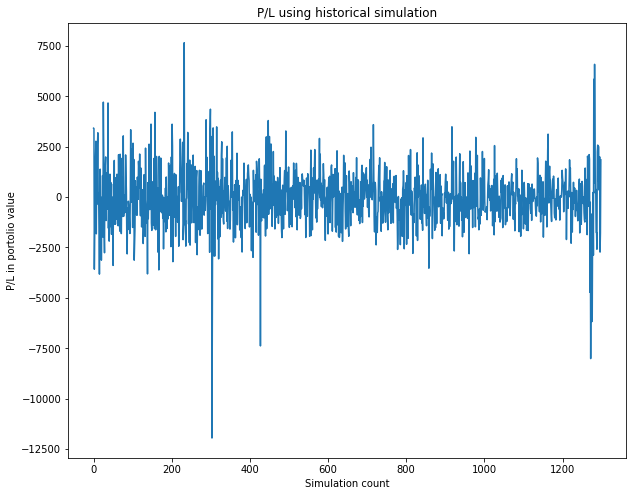

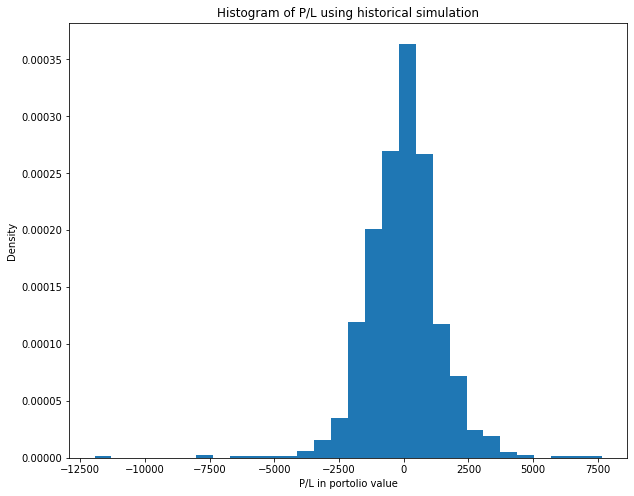

In [87]:
plt.figure(figsize=(10, 8))
plt.plot(histSimulation)
plt.ylabel('P/L in portolio value')
plt.xlabel('Simulation count')
plt.title('P/L using historical simulation')
plt.show()

print('\n')

plt.figure(figsize=(10, 8))
plt.hist(histSimulation, density=True, bins=30)
plt.xlabel('P/L in portolio value')
plt.ylabel('Density')
plt.title('Histogram of P/L using historical simulation')
plt.show()

In [0]:
def createHistSim(returns, rates, num_days):
    '''
        Returns = Changes in for each FX rate
        Rates = The spot rate of currencies
        Num_days = Number of days
    '''
    for i in range(num_days):
        rates = rates * (1 + returns)
    
    payments = rates * paymentsLocal
    return sum(payments)

conf_levels = [0.10, 0.05, 0.01]
paymentsLocal = np.array([100000, 100000, 100000]) #100K in local currencies
current_spot_rates = data.iloc[-1].to_numpy()
totalEarningUSD = current_spot_rates.dot(paymentsLocal)

In [92]:
# For 30 Day
num_days = 30
histSim = np.array([createHistSim(np.array(df_changes.iloc[i, :]), current_spot_rates, num_days) for i in range(df_changes.shape[0])])

# calculating VaR
hist_VaRs_30 = [abs(totalEarningUSD - np.percentile(histSim, conf_level * 100)) for conf_level in conf_levels]
tabulateData(hist_VaRs_30, conf_levels, title='VaR at {0} days'.format(num_days))

print('\n')

# calculating VaR
hist_CVaRs_30 = [abs(totalEarningUSD - np.mean(histSim[histSim < np.percentile(histSim, conf_level * 100)])) for conf_level in conf_levels]
tabulateData(hist_CVaRs_30, conf_levels, title='CVaR at {0} days'.format(num_days))

Confidence Level      VaR at 30 days
------------------  ----------------
90.0%                        41995.7
95.0%                        54578.1
99.0%                        80471.7


Confidence Level      CVaR at 30 days
------------------  -----------------
90.0%                         61169.5
95.0%                         74360.2
99.0%                        116646


# Monte-Carlo Simulation

In [0]:
num_simulations = 4000
num_days = 30

df_simulation = pd.DataFrame()

paymentsLocal = np.array([100000, 100000, 100000])
starting_point = paymentsLocal * data.iloc[-1]
totalEarningUSD = sum(starting_point)

for i in range(num_simulations):

    sim_usd_values = starting_point.to_numpy()
    sim_portfolio = [sum(sim_usd_values)]

    for j in range(num_days):
        # Using a normal multivariate distribution with a covariate matrix to get returns for each FX.
        sim_returns = np.random.multivariate_normal([0, 0, 0], cov_matrix)
        sim_usd_values = (1 + sim_returns) * sim_usd_values
        sim_portfolio.append(sum(sim_usd_values))

    df_simulation[i] = sim_portfolio


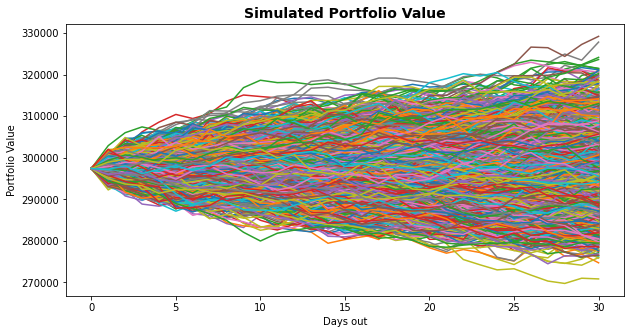

In [94]:
# Plotting the simulated value of our portfolio.
plt.figure(figsize=(10,5))
plt.plot(df_simulation) 
plt.xlabel('Days out')
plt.ylabel('Portfolio Value')
plt.title(r'Simulated Portfolio Value', fontsize=14, fontweight='bold')
plt.show() 

In [95]:
# sim_VaRs
sim_VaRs = [abs(totalEarningUSD -  np.percentile(df_simulation.iloc[1], conf_level * 100)) for conf_level in conf_levels]
tabulateData(sim_VaRs, conf_levels, title='Simulated VaR')
print('\n\n')

#CVaRs
sim_CVaRs = [abs(totalEarningUSD - np.mean(df_simulation.iloc[1][df_simulation.iloc[1] < np.percentile(df_simulation.iloc[1], conf_level * 100)])) for conf_level in conf_levels]
tabulateData(sim_CVaRs, conf_levels, title='Simulated CVaR')

Confidence Level      Simulated VaR
------------------  ---------------
90.0%                       1870.13
95.0%                       2384.45
99.0%                       3290.55



Confidence Level      Simulated CVaR
------------------  ----------------
90.0%                        2535.18
95.0%                        2975.3
99.0%                        3790.02


In [96]:
num_days = 30

# sim_VaRs
sim_VaRs_30 = [abs(totalEarningUSD -  np.percentile(df_simulation.iloc[num_days], conf_level * 100)) for conf_level in conf_levels]
tabulateData(sim_VaRs_30, conf_levels, title='Simulated VaR')
print('\n\n')

#CVaRs
sim_CVaRs_30 = [abs(totalEarningUSD - np.mean(df_simulation.iloc[num_days][df_simulation.iloc[num_days] < np.percentile(df_simulation.iloc[num_days], conf_level * 100)])) for conf_level in conf_levels]
tabulateData(sim_CVaRs_30, conf_levels, title='Simulated CVaR')

Confidence Level      Simulated VaR
------------------  ---------------
90.0%                       9690.82
95.0%                      12094.5
99.0%                      17343.7



Confidence Level      Simulated CVaR
------------------  ----------------
90.0%                        12998.2
95.0%                        15199.3
99.0%                        19248.4


# Results compilation

In [116]:
print('VaR at 1 day using different approaches')
df_results_VaRs_1_day = pd.DataFrame({
    'Confidence Level (%)': ['90%', '95%', '99%'],
    'Parametric Approach': np.round(parametric_VaRs,2),
    'Historical Approach': np.round(hist_VaRs, 2),
    'Simulated Approach': np.round(sim_VaRs, 2)
})

display(df_results_VaRs_1_day)
print('\n\n')

print('CVaR at 1 day using different approaches')
print('--'*20)
df_results_CVaRs_1_day = pd.DataFrame({
    'Confidence Level (%)': ['90%', '95%', '99%'],
    'Parametric Approach': np.round(parametric_CVaRs,2),
    'Historical Approach': np.round(hist_CVaRs, 2),
    'Simulated Approach': np.round(sim_CVaRs, 2)
})
display(df_results_CVaRs_1_day)

VaR at 1 day using different approaches


,Confidence Level (%),Parametric Approach,Historical Approach,Simulated Approach
0,90%,1771.90,1609.10,1870.13
1,95%,2281.13,1986.94,2384.45
2,99%,3236.38,3208.34,3290.55





CVaR at 1 day using different approaches
----------------------------------------


,Confidence Level (%),Parametric Approach,Historical Approach,Simulated Approach
0,90%,2435.50,2444.18,2535.18
1,95%,2866.84,3100.16,2975.30
2,99%,3711.37,5481.62,3790.02


In [117]:
print('VaR at 30 day using different approaches')
print('--'*20)
df_results_VaRs_30_day = pd.DataFrame({
    'Confidence Level (%)': ['90%', '95%', '99%'],
    'Parametric Approach': np.round(VaR_n_day, 2),
    'Historical Approach': np.round(hist_VaRs_30, 2),
    'Simulated Approach': np.round(sim_VaRs_30, 2)
})

display(df_results_VaRs_30_day)

print('\n\n')
print('CVaR at 30 day using different approaches')
print('--'*20)
df_results_CVaRs_30_day = pd.DataFrame({
    'Confidence Level (%)': ['90%', '95%', '99%'],
    'Parametric Approach': np.round(CVaR_n_day, 2),
    'Historical Approach': np.round(hist_CVaRs_30, 2),
    'Simulated Approach': np.round(sim_CVaRs_30, 2)
})

display(df_results_CVaRs_30_day)

VaR at 30 day using different approaches
----------------------------------------


,Confidence Level (%),Parametric Approach,Historical Approach,Simulated Approach
0,90%,9705.07,41995.68,9690.82
1,95%,12494.28,54578.13,12094.49
2,99%,17726.39,80471.71,17343.67





CVaR at 30 day using different approaches
----------------------------------------


,Confidence Level (%),Parametric Approach,Historical Approach,Simulated Approach
0,90%,13339.79,61169.46,12998.24
1,95%,15702.36,74360.22,15199.32
2,99%,20328.00,116645.85,19248.45


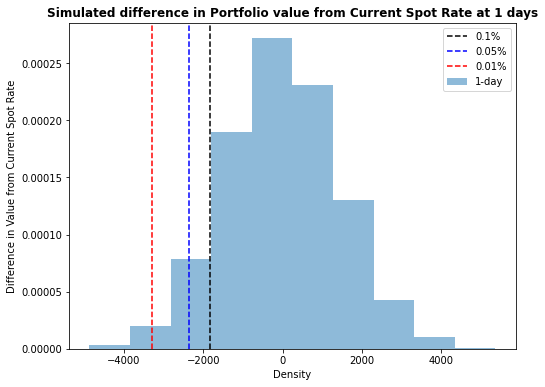

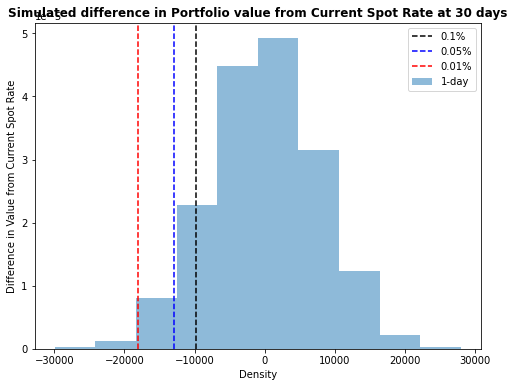

In [268]:
def plot_hist(df, num_days, conf_levels):
    diff_vals = df.iloc[0] - df.iloc[num_days]
    plt.figure(figsize=(8,6))
    plt.hist(diff_vals, density=True, alpha=0.5, label='1-day')
    colors = ['k', 'b', 'r']
    for idx, conf_level in enumerate(conf_levels):
        plt.axvline(np.percentile(diff_vals, conf_level * 100), color=colors[idx],
                    linestyle='--', label='{0}%'.format(conf_level))
    plt.ylabel('Difference in Value from Current Spot Rate')
    plt.xlabel('Density')
    plt.legend()
    plt.title(r'Simulated difference in Portfolio value from Current Spot Rate at {0} days'.format(num_days), fontsize=12, fontweight='bold')
    plt.show()


plot_hist(df_simulation, 1, conf_levels)
plot_hist(df_simulation, num_days, conf_levels)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


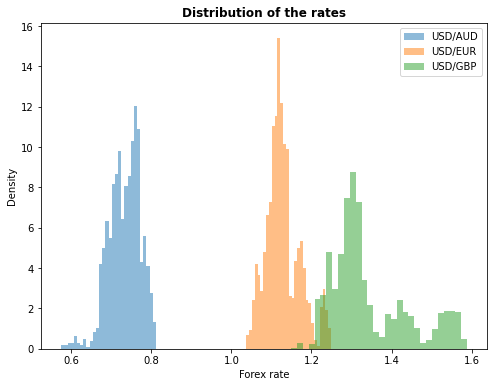

In [132]:
plt.figure(figsize=(8, 6))
plt.hist(data['DEXUSAL'], alpha=0.5, label='USD/AUD', density=True, bins=30)
plt.hist(data['DEXUSEU'], alpha=0.5, label='USD/EUR', density=True, bins=30)
plt.hist(data['DEXUSUK'], alpha=0.5, label='USD/GBP', density=True, bins=30)
plt.xlabel('Forex rate')
plt.ylabel('Density')
plt.title(r'Distribution of the rates'.format(num_days), fontsize=12, fontweight='bold')
plt.legend()
plt.show()

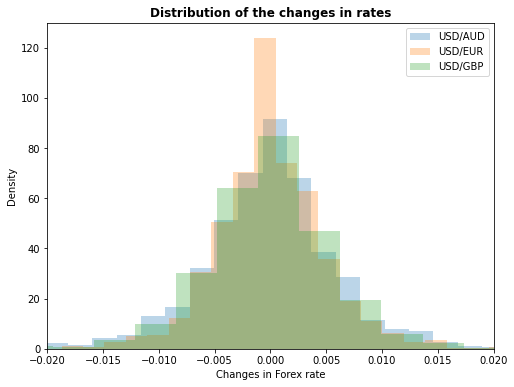

In [133]:
plt.figure(figsize=(8, 6))
plt.hist(df_changes['DEXUSAL'], alpha=0.3, label='USD/AUD', density=True, bins=30)
plt.hist(df_changes['DEXUSEU'], alpha=0.3, label='USD/EUR', density=True, bins=30)
plt.hist(df_changes['DEXUSUK'], alpha=0.3, label='USD/GBP', density=True, bins=30)
plt.xlabel('Changes in Forex rate')
plt.ylabel('Density')
plt.title(r'Distribution of the changes in rates'.format(num_days), fontsize=12, fontweight='bold')
plt.xlim(-0.02, 0.02)
plt.legend()
plt.show()

In [0]:
plt.xlim()
